<a href="https://colab.research.google.com/github/federicochiarello/Hands-On-ML-Notebooks/blob/master/03_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

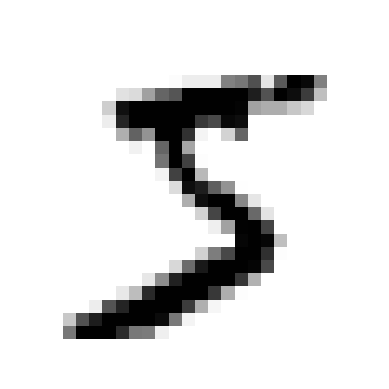

In [6]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [7]:
y[0]

'5'

In [8]:
type(y)

numpy.ndarray

In [9]:
y = y.astype(np.uint8)

In [10]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)

    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)

    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

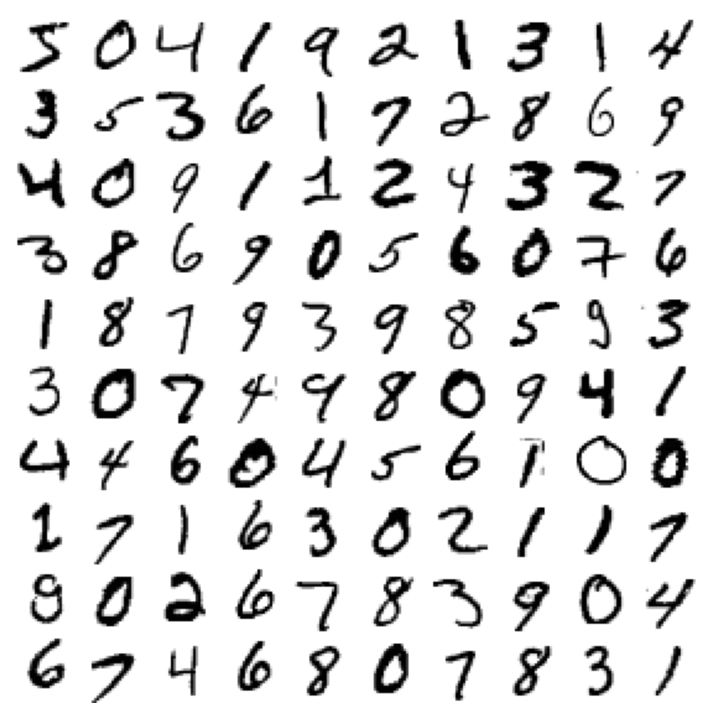

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index, in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
from sklearn.model_selection import cross_val_score

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [21]:
y_train_pred_never_5 = cross_val_predict(never_5_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred_never_5)

array([[54579,     0],
       [ 5421,     0]])

## Precision and Recall

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [24]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Trade-off

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

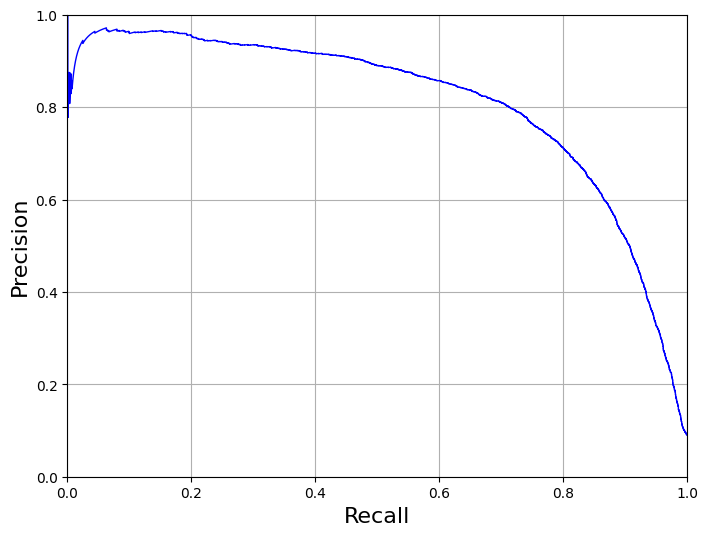

In [27]:
def plot_precision_vs_recall(precisions, recalls, label=None):
    plt.plot(recalls, precisions, 'b-', linewidth=1, label=label)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0,1,0,1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

## ROC Curve

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

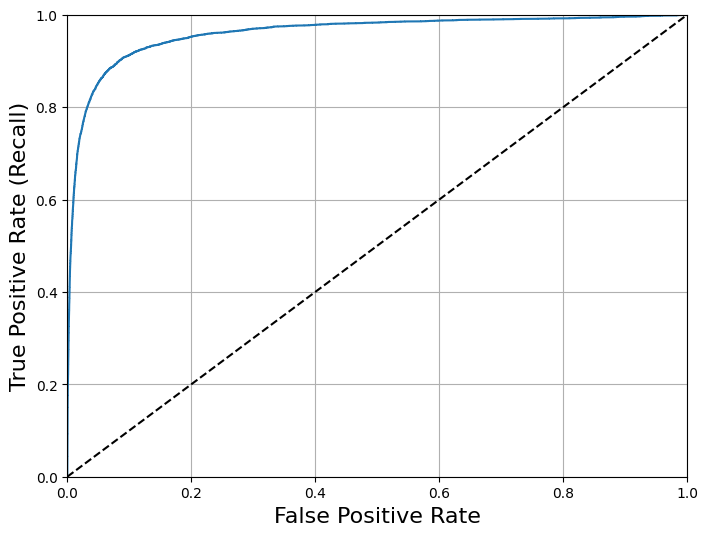

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [32]:
y_scores_forest = y_probs_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

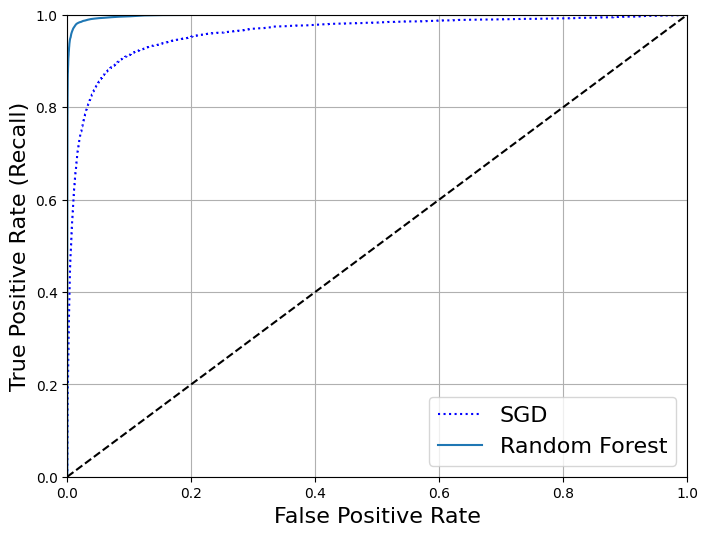

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.legend(loc='lower right', fontsize=16)
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores) # SGDClassifier

0.9604938554008616

In [35]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
roc_auc_score(y_train_5, y_train_pred_forest) # Random Forest

0.9327181722735077

# Multiclass Classification

In [36]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto', random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [37]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [38]:
np.argmax(some_digit_scores)

5

# Multilabel Classification

In [39]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [40]:
knn_clf.predict([some_digit])

array([[False,  True]])

# Multioutput Classification

In [41]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

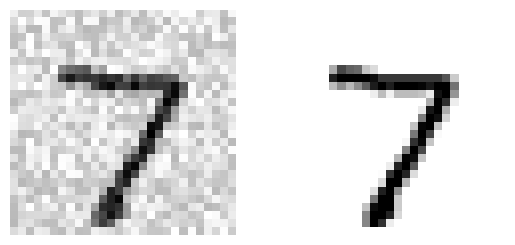

In [42]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

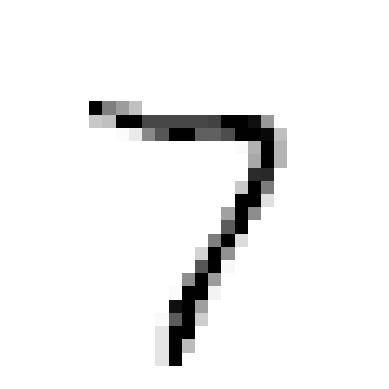

In [43]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Dummy Classifier

In [44]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier(strategy='prior')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_dmy = y_probas_dmy[:, 1]

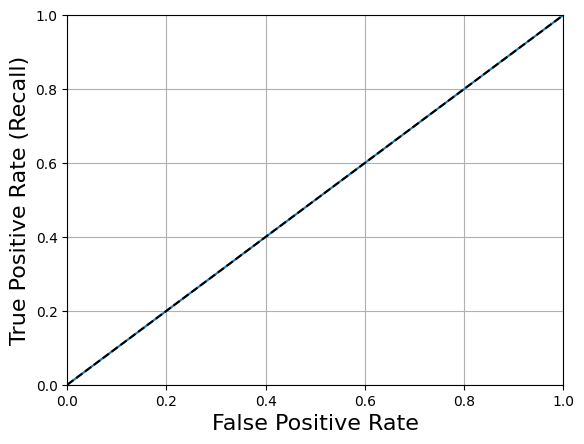

In [45]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

# Titanic Dataset

Goal: predict whether or not a passanger survived

In [46]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()    

In [47]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [48]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

## EDA

In [49]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

In [50]:
# set the PassangerId column as the index

train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


_Age_, _Cabin_ and _Embarked_ attributes are sometimes null

In [52]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [53]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [54]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [55]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [56]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Pipeline

### Numerical

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

### Categorical

In [58]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse_output=False)),
])

### Full Pipeline

In [59]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocessing_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

In [60]:
X_train = preprocessing_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs]
)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [61]:
X_train.shape

(891, 12)

In [62]:
y_train = train_data['Survived']

## Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [64]:
X_test = preprocessing_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

In [65]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

In [66]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

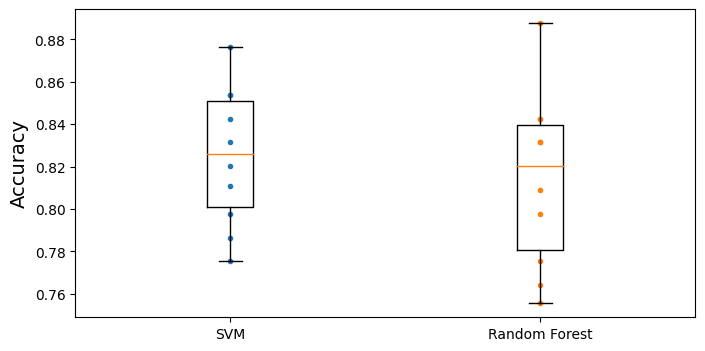

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))
plt.ylabel('Accuracy', fontsize=14)
plt.show()

## Feature Engineering

  * Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
  * Replace **SibSp** and **Parch** with their sum.
  * Try to identify parts of names that correlate well with the **Survived** attribute.
  * Use the **Cabin** column, for example take its first letter and treat it as a categorical attribute.

In [68]:
# original training data (to be used in the pipeline)
original_train_data = train_data.copy()

In [69]:
train_data['AgeBucket'] = train_data['Age'] // 15 * 15
train_data[['AgeBucket', 'Survived']].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [70]:
train_data['RelativeOnboard'] = train_data['SibSp'] + train_data['Parch']
train_data[['RelativeOnboard', 'Survived']].groupby(['RelativeOnboard']).mean()

,Survived
RelativeOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [71]:
train_data['AloneTraveler'] = train_data['RelativeOnboard'] == 0
train_data[['AloneTraveler', 'Survived']].groupby(['AloneTraveler']).mean()

,Survived
AloneTraveler,
False,0.505650
True,0.303538


In [72]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    int64  
 1   Pclass           891 non-null    int64  
 2   Name             891 non-null    object 
 3   Sex              891 non-null    object 
 4   Age              714 non-null    float64
 5   SibSp            891 non-null    int64  
 6   Parch            891 non-null    int64  
 7   Ticket           891 non-null    object 
 8   Fare             891 non-null    float64
 9   Cabin            204 non-null    object 
 10  Embarked         889 non-null    object 
 11  AgeBucket        714 non-null    float64
 12  RelativeOnboard  891 non-null    int64  
 13  AloneTraveler    891 non-null    bool   
dtypes: bool(1), float64(3), int64(5), object(5)
memory usage: 98.3+ KB


## New Pipeline

In [73]:
train_data = original_train_data

In [74]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [75]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [76]:
from sklearn.preprocessing import Binarizer

binarizer = Binarizer(threshold=0)

binarizer.transform([[1,0,1], [2,0,0]])

array([[1, 0, 1],
       [1, 0, 0]])

In [77]:
from sklearn.base import BaseEstimator

class AgeBucketComputer(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X // 15 * 15

# est = AgeBucketComputer()
# est.transform(train_data.Age)

In [78]:
from sklearn.base import BaseEstimator

# column index
# col_names = 'SibSp', 'Parch'
# SibSp_ix, Parch_ix = [train_data.columns.get_loc(c) for c in col_names]
SibSp_ix, Parch_ix = 1, 2

class RelativesAttributeAdder(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # relativeOnboard = X['SibSp'] + X['Parch']
        relativeOnboard = X[:, SibSp_ix] + X[:, Parch_ix]
        aloneTraveler = relativeOnboard == 0
        return np.c_[X, relativeOnboard, aloneTraveler]

# est = RelativesAttributeAdder()
# est.transform(train_data[['SibSp', 'Parch']])

In [79]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('relatives_attribute_adder', RelativesAttributeAdder()),
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse_output=False)),
])

age_bucket_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('age_bucket_computer', AgeBucketComputer()),
    ('cat_encoder', OneHotEncoder(sparse_output=False))
])

num_attribs = ['Fare', 'SibSp', 'Parch']
cat_attribs = ['Pclass', 'Sex', 'Embarked']
age_attribs = ['Age']

preprocessing_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
    ('age_bucket', age_bucket_pipeline, age_attribs),
])

In [80]:
X_train = preprocessing_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs + age_attribs]
)
X_train

array([[-0.50244517,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78684529,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  0.        ],
       [-0.48885426, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.17626324,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04438104, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49237783, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  0.        ]])

In [81]:
X_train[0]

array([-0.50244517,  0.43279337, -0.47367361,  0.05915988, -1.2316449 ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [82]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [83]:
X_test = preprocessing_pipeline.transform(test_data[age_attribs + num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

In [84]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8092384519350813